In [1]:
!pip install evaluate

import pandas as pd
from collections import Counter
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import (
    CLIPProcessor,
    CLIPModel
)
from transformers.modeling_outputs import SequenceClassifierOutput
from PIL import Image
from tqdm import tqdm
import evaluate
import ast
import sklearn
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00


In [2]:
TRAIN_CSV = "/kaggle/input/simplified-task/train_data.csv"
VAL_CSV = "/kaggle/input/simplified-task/validation_data.csv"
TR_IMAGE_DIR = "/kaggle/input/simplified-task/Dataset/Dataset/Dataset/Train/"
VAL_IMAGE_DIR = "/kaggle/input/simplified-task/Dataset/Dataset/Dataset/Validation/"
TEACHER_PATH = "openai/clip-vit-base-patch32"
BATCH_SIZE = 32
NUM_CLASSES = 4

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)

print("Unique values for Train: " + str({**Counter(train_df.text)}))
print("Unique values for Validation: " + str({**Counter(val_df.text)}))

Unique values for Train: {'Belkart': 216, 'Mastercard': 213, 'Mir': 202, 'Visa Mastercard Mir': 226, 'Visa': 213, 'Visa Mastercard Belkart': 200, 'Mastercard Belkart Mir': 201, 'Visa Mir': 201, 'Accept': 190, 'Belkart Password': 201, 'ID-Check Belkart Password': 201, 'ID-Check Belkart': 200, 'ID-Check Mastercard': 201, 'ID-Check': 198, 'Mir Accept': 201, 'Password': 198, 'Secure ID-Check': 201, 'Secure': 202, 'Visa Secure': 201, 'Other': 201}
Unique values for Validation: {'Visa Mastercard Mir': 101, 'Visa Mastercard': 100, 'Visa Mastercard Belkart': 200, 'ID-Check Accept Secure Password': 101, 'ID-Check Secure Password': 101}


In [4]:
train_df = train_df[(train_df.text == "Visa Mir") | 
                    (train_df.text == "Visa") | 
                    (train_df.text == "Other") |
                    (train_df.text == "Mir") | 
                    (train_df.text == "Mastercard") |
                    (train_df.text == "Visa Mastercard Mir")]

val_df = val_df[(val_df.text == "Visa Mastercard Mir") |
                (val_df.text == "Visa Mastercard") |
                (val_df.text == "Visa Mastercard Belkart")]

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [5]:
train_df.loc[:, "labels"] = train_df.labels.apply(ast.literal_eval)
train_df.loc[:, "labels"] = train_df.labels.apply(np.float32)

val_df.loc[:, "labels"] = val_df.labels.apply(ast.literal_eval)
val_df.loc[:, "labels"] = val_df.labels.apply(np.float32)

In [8]:
class Loader(Dataset):
    def __init__(self, data_dir, df, processor):
        super().__init__()
        self.data_dir = data_dir
        self.df = df
        self.processor = processor

    
    def __len__(self):
        return len(self.df)


    def __getitem__(self, index):
        file_name = self.df["file_name"][index]
        labels = self.df["labels"][index]
        text = self.df["text"][index]
        image = Image.open(self.data_dir + file_name).convert("RGBA")
        pixel_values = self.processor.image_processor(image, return_tensors="pt").pixel_values
        input_ids = self.processor.tokenizer(text, padding="max_length", truncation=True)
        
        return {"pixel_values": pixel_values.squeeze(),
                "input_ids": torch.tensor(input_ids.input_ids),
                "attention_mask": torch.tensor(input_ids.attention_mask),
                "labels": torch.tensor(labels)}

In [9]:
processor = CLIPProcessor.from_pretrained(TEACHER_PATH)

train_dataset = Loader(data_dir=TR_IMAGE_DIR, df=train_df,
                       processor=processor)

val_dataset = Loader(data_dir=VAL_IMAGE_DIR, df=val_df,
                      processor=processor)

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [10]:
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True)

eval_dataloader = DataLoader(val_dataset, 
                             batch_size=BATCH_SIZE)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLIP = CLIPModel.from_pretrained(TEACHER_PATH,attn_implementation="sdpa").to(device)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [100]:
for param in CLIP.named_parameters():
    if (param[0] == 'visual_projection.weight' or
        param[0] == 'text_projection.weight' or
        param[0] == "logit_scale"):
        continue
    else:
        param[1].requires_grad=True

In [53]:
""""optimizer = torch.optim.SGD(CLIP.parameters(),
                            lr=1e-4,
                            momentum=0.999)""""

In [101]:
optimizer = torch.optim.AdamW(CLIP.parameters(),
                              lr=1e-4)

In [102]:
def plot_grad_flow(named_parameters):
    global ave_grads
    ave_grads = []
    global layers
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


Training Loss: 3.351712906360626


100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


Training Loss: 2.1245479017496107


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


Training Loss: 1.8038956582546235


100%|██████████| 40/40 [00:28<00:00,  1.41it/s]


Training Loss: 1.7901268899440765


100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


Training Loss: 1.763461822271347


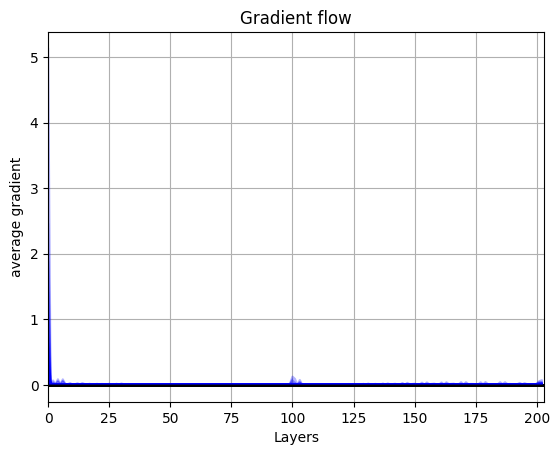

In [103]:
iter = []
for epoch in range(5):
    train_loss = 0.0
    CLIP.train()
    for batch in tqdm(train_dataloader):
        for k,v in batch.items():
            batch[k] = v.to(device)
            
        outputs = CLIP(pixel_values=batch["pixel_values"],
                       input_ids=batch["input_ids"],
                       attention_mask=batch["attention_mask"],
                       return_loss=True)

        loss = outputs.loss
        loss.backward()
        plot_grad_flow(CLIP.named_parameters())
        iter.append(ave_grads)
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()

    """CLIP.eval()
    eval_loss=0.0
    for batch in tqdm(eval_dataloader):
        for k,v in batch.items():
            batch[k] = v.to(device)

        outputs = CLIP(pixel_values=batch["pixel_values"],
                      input_ids=batch["input_ids"],
                      attention_mask=batch["attention_mask"],
                      return_loss=True)

        loss=outputs.loss
        eval_loss+=loss.item()"""

        
    print("Training Loss: " + str(train_loss / len(train_dataloader)))
    #print("Validation Loss: " + str(eval_loss / len(eval_dataloader)))

In [110]:
train_df[train_df.text == "Visa.Mir"].index

Index([ 854,  855,  856,  857,  858,  859,  860,  861,  862,  863,
       ...
       1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054],
      dtype='int64', length=201)

In [111]:
image = train_dataset[1051]["pixel_values"].unsqueeze(0).to(device)
text = processor.tokenizer(text=["a photo of Visa","a photo of Mastercard", "a photo of Mir",
                                 "a photo of Other"],
                          return_tensors="pt",
                          padding=True).to(device)

outputs = CLIP(pixel_values=image, input_ids=text["input_ids"])
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=-1)
print(torch.round(probs, decimals=3))

tensor([[0.0010, 0.0000, 0.8870, 0.1120]], device='cuda:0',
       grad_fn=<RoundBackward1>)


In [12]:
class CustomModel(nn.Module):
    def __init__(self, model, num_labels):
        super(CustomModel,self).__init__()
        self.num_labels = num_labels
        self.model = model
        self.classifier = nn.Linear(model.vision_model.config.hidden_size,num_labels)
    

    def forward(self, pixel_values, labels=None):

        outputs = self.model.vision_model(pixel_values=pixel_values,
                                          output_hidden_states=True)

        pooler_output = outputs.pooler_output
        logits = self.classifier(pooler_output)          
        
        loss=None
        if labels is not None:
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))

    
        return SequenceClassifierOutput(loss=loss, logits=logits)

model = CustomModel(CLIP, NUM_CLASSES).to(device)

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
f1 = evaluate.load("f1", trust_remote_code=True)

In [14]:
preds = []

for epoch in range(5):
    model.train()
    train_loss=0.0
    for batch in tqdm(train_dataloader):
        for k,v in batch.items():
            batch[k] = v.to(device)
            
        outputs = model(pixel_values=batch["pixel_values"],
                        labels=batch["labels"])
        
        loss = outputs.loss
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dataloader):
            for k,v in batch.items():
                batch[k] = v.to(device)
         
            outputs = model(pixel_values=batch["pixel_values"])

            logits = outputs.logits
            activation = torch.sigmoid(logits)
            predictions = (activation >= 0.5).float()
            preds.append(predictions)
            for indx in range(activation.shape[0]):
                f1.add_batch(predictions=predictions[indx],
                             references=batch["labels"][indx])
        
    
    print("Training Loss: " + str(train_loss / len(train_dataloader)))     
    print(f1.compute(average='binary'))

100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Training Loss: 0.17569373662117868
{'f1': 0.2659574468085107}


100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


Training Loss: 0.011339819460408762
{'f1': 0.2659574468085107}


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Training Loss: 0.004114532720996067
{'f1': 0.2659574468085107}


 45%|████▌     | 18/40 [00:09<00:11,  1.93it/s]


KeyboardInterrupt: 

In [15]:
pred = torch.cat(preds, dim=0)
true = torch.tensor(val_df["labels"], dtype=torch.float32)

print(sklearn.metrics.classification_report(
    true.cpu().numpy(),
    pred[-true.shape[0]:].cpu().numpy(),
    target_names=["Mastercard",
                  "Visa",
                  "Мир",
                  "Иные"]
))

              precision    recall  f1-score   support

  Mastercard       0.00      0.00      0.00       401
        Visa       0.00      0.00      0.00       401
         Мир       0.00      0.00      0.00       101
        Иные       0.50      1.00      0.67       200

   micro avg       0.50      0.18      0.27      1103
   macro avg       0.12      0.25      0.17      1103
weighted avg       0.09      0.18      0.12      1103
 samples avg       0.50      0.17      0.25      1103



/tmp/ipykernel_23/4210245038.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  true = torch.tensor(val_df["labels"], dtype=torch.float32)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
